### Anomaly Detection with ORACLE

In [37]:
!pip install numpy polars tqdm astropy tf_keras tensorflow dataframe_image==0.2.5
# uncomment line above if necessary
import os
import pickle
import numpy as np
import polars as pl
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from collections import OrderedDict
from taxonomy import get_classification_labels, get_astrophysical_class, plot_colored_tree
import tf_keras as keras
import tensorflow as tf
import itertools
os.environ["TF_USE_LEGACY_KERAS"] = "1"

   ---------------------------------------- 0.0/6.7 MB ? eta -:--:--
   - -------------------------------------- 0.3/6.7 MB ? eta -:--:--
   ------ --------------------------------- 1.0/6.7 MB 3.1 MB/s eta 0:00:02
   --------- ------------------------------ 1.6/6.7 MB 3.2 MB/s eta 0:00:02
   ------------ --------------------------- 2.1/6.7 MB 3.1 MB/s eta 0:00:02
   -------------- ------------------------- 2.4/6.7 MB 2.6 MB/s eta 0:00:02
   --------------- ------------------------ 2.6/6.7 MB 2.3 MB/s eta 0:00:02
   ----------------- ---------------------- 2.9/6.7 MB 2.2 MB/s eta 0:00:02
   ------------------ --------------------- 3.1/6.7 MB 2.1 MB/s eta 0:00:02
   ---------------------- ----------------- 3.7/6.7 MB 2.0 MB/s eta 0:00:02
   ----------------------- ---------------- 3.9/6.7 MB 2.0 MB/s eta 0:00:02
   ------------------------- -------------- 4.2/6.7 MB 2.0 MB/s eta 0:00:02
   ---------------------------- ----------- 4.7/6.7 MB 2.0 MB/s eta 0:00:01
   -----------------------


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


**Reading in Parquet files using Polars**

In [3]:
static_feature_list = ['MWEBV', 'MWEBV_ERR', 'REDSHIFT_HELIO', 'REDSHIFT_HELIO_ERR', 'HOSTGAL_PHOTOZ', 'HOSTGAL_PHOTOZ_ERR', 'HOSTGAL_SPECZ', 'HOSTGAL_SPECZ_ERR', 'HOSTGAL_RA', 'HOSTGAL_DEC', 'HOSTGAL_SNSEP', 'HOSTGAL_ELLIPTICITY', 'HOSTGAL_MAG_u', 'HOSTGAL_MAG_g', 'HOSTGAL_MAG_r', 'HOSTGAL_MAG_i', 'HOSTGAL_MAG_z', 'HOSTGAL_MAG_Y', 'MW_plane_flag', 'ELAIS_S1_flag', 'XMM-LSS_flag', 'Extended_Chandra_Deep_Field-South_flag', 'COSMOS_flag']

In [3]:
train_path = "./../../train_parquet-001.parquet"
# test_path = "./../../test_parquet-002.parquet"
train_parquet = pl.read_parquet(train_path)
train_parquet.head()['BAND']

shape: (5,)
Series: 'BAND' [list[str]]
[
	["r", "i", … "Y"]
	["z", "Y", … "i"]
	["Y", "g", … "r"]
	["i", "z", … "z"]
	["Y", "Y", … "Y"]
]

In [4]:
# train_parquet.columns

In [7]:
# def get_class_info(parquet):
#     assert parquet.shape[0] > 1
#     classes = []
#     snids = []
#     for row in range(parquet.shape[0]):
#         classes.append(parquet[row]["ELASTICC_class"].to_numpy()[0])
#         snids.append(parquet[row]["SNID"].to_numpy()[0])

#     return classes, snids

# classes, snids = get_class_info(train_parquet.head())
# print(list(zip(classes, snids)))

The following `LSST_Source()` class creates an object for each individual lightcurve that computes and stores the flux values (and other time-series data), as well as the static features associated with the lightcurve.

The `LSSTSourceDataSet()` class then stores the collection of `LSST_Source` objects from all the lightcurves in the Polars DataFrame.

In [2]:
class LSST_Source:

    # List of time series features actually stored in the instance of the class.
    time_series_features = ['MJD', 'BAND', 'PHOTFLAG', 'FLUXCAL', 'FLUXCALERR']

    # List of other features actually stored in the instance of the class.
    other_features = ['RA', 'DEC', 'MWEBV', 'MWEBV_ERR', 'REDSHIFT_HELIO', 'REDSHIFT_HELIO_ERR', 'VPEC', 'VPEC_ERR', 'HOSTGAL_PHOTOZ', 'HOSTGAL_PHOTOZ_ERR', 'HOSTGAL_SPECZ', 'HOSTGAL_SPECZ_ERR', 'HOSTGAL_RA', 'HOSTGAL_DEC', 'HOSTGAL_SNSEP', 'HOSTGAL_DDLR', 'HOSTGAL_LOGMASS', 'HOSTGAL_LOGMASS_ERR', 'HOSTGAL_LOGSFR', 'HOSTGAL_LOGSFR_ERR', 'HOSTGAL_LOGsSFR', 'HOSTGAL_LOGsSFR_ERR', 'HOSTGAL_COLOR', 'HOSTGAL_COLOR_ERR', 'HOSTGAL_ELLIPTICITY', 'HOSTGAL_MAG_u', 'HOSTGAL_MAG_g', 'HOSTGAL_MAG_r', 'HOSTGAL_MAG_i', 'HOSTGAL_MAG_z', 'HOSTGAL_MAG_Y', 'HOSTGAL_MAGERR_u', 'HOSTGAL_MAGERR_g', 'HOSTGAL_MAGERR_r', 'HOSTGAL_MAGERR_i', 'HOSTGAL_MAGERR_z', 'HOSTGAL_MAGERR_Y']

    # Additional features computed based on time_series_features and other_features mentioned in SNANA fits.
    custom_engineered_features = ['MW_plane_flag', 'ELAIS_S1_flag', 'XMM-LSS_flag', 'Extended_Chandra_Deep_Field-South_flag', 'COSMOS_flag']

    # Get the mean wavelengths for each filter and then convert to micro meters
    pb_wavelengths = {
        'u': (320 + 400) / (2 * 1000),
        'g': (400 + 552) / (2 * 1000),
        'r': (552 + 691) / (2 * 1000),
        'i': (691 + 818) / (2 * 1000),
        'z': (818 + 922) / (2 * 1000),
        'Y': (950 + 1080) / (2 * 1000),
    }

    # Pass band to color dict
    colors = OrderedDict({
        'u': 'blue',
        'g': 'green',
        'r': 'red',
        'i': 'teal',
        'z': 'orange',
        'Y': 'purple',
    })

    # 6 broadband filters used in LSST.
    LSST_bands = list(colors.keys())

    # Coordinates for LSST's 4 selected deep drilling fields. (Reference: https://www.lsst.org/scientists/survey-design/ddf)
    LSST_DDF = {
        'ELAIS_S1': SkyCoord(l=311.30 * u.deg, b=-72.90 * u.deg, frame='galactic'),
        'XMM-LSS': SkyCoord(l=171.20 * u.deg, b=-58.77 * u.deg, frame='galactic'),
        'Extended_Chandra_Deep_Field-South': SkyCoord(l=224.07 * u.deg, b=-54.47 * u.deg, frame='galactic'),
        'COSMOS': SkyCoord(l=236.83 * u.deg, b=42.09 * u.deg, frame='galactic'),
    }


    # Threshold values

    # MW_plane_flag is set to one if |self.b| <= b_threshold. Indicative of weather the object is in the galactic plane.
    b_threshold = 15 

    # Flux scaling value
    flux_scaling_const = 1000

    # Radius of the deep drilling field for LSST, in degrees.
    ddf_separation_radius_threshold = 3.5 / 2


    def __init__(self, parquet_row) -> None:
        """Create an LSST_Source object to store both photometric and host galaxy data from the Elasticc simulations.

        Args:
            parquet_row (_type_): A row from the polars data frame that was generated from the Elasticc FITS files using fits_to_parquet.py
            class_label (str): The Elasticc class label for this LSST_Source object.
        """

        # Set all the class attributes
        setattr(self, 'ELASTICC_class', parquet_row['ELASTICC_class'].to_numpy()[0])
        setattr(self, 'SNID', parquet_row['SNID'].to_numpy()[0])
        setattr(self, 'astrophysical_class', get_astrophysical_class(self.ELASTICC_class))

        for key in parquet_row.columns:
            if key in self.other_features:
                setattr(self, key, parquet_row[key].to_numpy()[0])
            elif key in self.time_series_features:
                setattr(self, key, parquet_row[key][0].to_numpy())

        # Run processing code on the light curves
        self.process_lightcurve()

        # Computer additional features
        self.compute_custom_features()

    
    def process_lightcurve(self) -> None:
        """Process the flux information with phot flags. Processing is done using the following steps:
        1. Remove saturations.
        Finally, all the time series data is modified to conform to the steps mentioned above.
        """

        # Remove saturations from the light curves
        saturation_mask =  (self.PHOTFLAG & 1024) == 0 

        # Alter time series data to remove saturations
        for time_series_feature in self.time_series_features:
            setattr(self, time_series_feature, getattr(self, time_series_feature)[saturation_mask])
        
    def compute_custom_features(self) -> None:

        source_coord = SkyCoord(ra = self.RA * u.deg, dec=self.DEC * u.deg)

        # Check if the object is close to the galactic plane of the milky way
        if abs(source_coord.galactic.b.degree) < self.b_threshold: 
            self.MW_plane_flag = 1
        else:
            self.MW_plane_flag = 0
        
        # Check if the object is in one of 4 LSST DDF's and set flags appropriately
        for key in self.LSST_DDF:

            # Separation from field center
            separation = source_coord.separation(self.LSST_DDF[key]).degree

            if separation < self.ddf_separation_radius_threshold:
                setattr(self, f'{key}_flag', 1)
            else:
                setattr(self, f'{key}_flag', 0)

        pass


    def plot_flux_curve(self) -> None:
        """Plot the SNANA calibrated flux vs time plot for all the data in the processed time series. All detections are marked with a star while non detections are marked with dots. Observations are color codded by their passband. This function is fundamentally a visualization tool and is not intended for making plots for papers.
        """

        # Colorize the data
        c = [self.colors[band] for band in self.BAND]
        patches = [mpatches.Patch(color=self.colors[band], label=band, linewidth=1) for band in self.colors]
        fmts = np.where((self.PHOTFLAG & 4096) != 0, '*', '.')

        # Plot flux time series
        for i in range(len(self.MJD)):
            plt.errorbar(x=self.MJD[i], y=self.FLUXCAL[i], yerr=self.FLUXCALERR[i], color=c[i], fmt=fmts[i], markersize = '10')

        # Labels
        plt.title(f"SNID: {self.SNID} | CLASS: {self.ELASTICC_class}")
        plt.xlabel('Time (MJD)')
        plt.ylabel('Calibrated Flux')
        plt.legend(handles=patches)

        plt.show()

    def get_classification_labels(self):
        """Get the classification labels (hierarchical) for this LSST Source object in the Taxonomy tree.

        Returns:
            (tree_nodes, numerical_labels): A tuple containing two list like objects. The first object contains the ordering of the nodes. The second list contains the labels themselves (0 when the object does not belong to the class and 1 when it does). The labels in the second object correspond to the nodes in the first object.
        """
        return get_classification_labels(self.astrophysical_class)
    
    def plot_classification_tree(self):
        """Plot the classification tree (based on our taxonomy) for this LSST Source object.
        """

        node, labels = self.get_classification_labels()
        plot_colored_tree(labels)


    def get_event_table(self):

        # Dataframe for time series data
        table = Table()

        # Find time since last observation
        time_since_first_obs = self.MJD - self.MJD[0]
        table['scaled_time_since_first_obs'] = time_since_first_obs / 100

        # 1 if it was a detection, zero otherwise
        table['detection_flag'] = np.where((self.PHOTFLAG & 4096 != 0), 1, 0)

        # Transform flux cal and flux cal err to more manageable values (more consistent order of magnitude)
        table['scaled_FLUXCAL'] = self.FLUXCAL / self.flux_scaling_const
        table['scaled_FLUXCALERR'] = self.FLUXCALERR / self.flux_scaling_const

        # One hot encoding for the pass band
        table['band_label'] = [self.pb_wavelengths[pb] for pb in self.BAND]

        # Consistency check
        assert len(table) == len(self.MJD), "Length of time series tensor does not match the number of mjd values."

        # Array for static features
        feature_static = OrderedDict()
        for other_feature in self.other_features:
            feature_static[other_feature] = getattr(self, other_feature)

        for feature in self.custom_engineered_features:
            feature_static[feature] = getattr(self, feature)

        # Array for computed static features
        table.meta = feature_static
        return table

    def __str__(self) -> str:

        to_return = str(vars(self))
        return to_return

In [3]:
class LSSTSourceDataSet():


    def __init__(self, path):
        """
        Arguments:
            path (string): Parquet file.
            transform (callable, optional): Optional transform to be applied on a sample.
        """

        print(f'Loading parquet dataset: {path}', flush=True)

        self.path = path
        self.parquet = pl.read_parquet(path)
        self.num_sample = self.parquet.shape[0]

        print(f"Number of sources: {self.num_sample}")

    def get_len(self):

        return self.num_sample

    def get_item(self, idx):
        
        row = self.parquet[idx]
        source = LSST_Source(row)
        table = source.get_event_table()

        astrophysical_class = get_astrophysical_class(source.ELASTICC_class)
        _, class_labels = get_classification_labels(astrophysical_class)
        class_labels = np.array(class_labels)

        return source, class_labels
    
    def get_dimensions(self):

        idx = 0
        source, class_labels = self.get_item(idx)
        table = source.get_event_table()

        ts_np = table.to_pandas().to_numpy()
        static_np = np.array(list(table.meta.values()))

        dims = {
            'ts': ts_np.shape[1],
            'static': static_np.shape[0],
            'labels': class_labels.shape[0]
        }

        return dims
    
    def get_labels(self):

        ELASTICC_labels = self.parquet['ELASTICC_class']
        astrophysical_labels = []

        for idx in range(self.num_sample):

            elasticc_class = ELASTICC_labels[idx]
            astrophysical_class = get_astrophysical_class(elasticc_class)
            astrophysical_labels.append(astrophysical_class)
        
        return astrophysical_labels

In [6]:
# printing out important lightcurve features/information from the LSST_Source objects
train = LSSTSourceDataSet("./../../train_parquet-001.parquet")
source, class_labels = train.get_item(9)
table = source.get_event_table()
print(table)
print(table.meta)

Loading parquet dataset: ./../../train_parquet-001.parquet
Number of sources: 1081614
scaled_time_since_first_obs detection_flag ... scaled_FLUXCALERR band_label
--------------------------- -------------- ... ----------------- ----------
                        0.0              0 ...      0.0059974254     0.7545
     0.00011400000003050081              0 ...      0.0049350527     0.6215
        0.01013200000001234              0 ...       0.007110095     0.7545
       0.010136000000056811              0 ...      0.0068634255     0.7545
       0.029884999999994763              0 ...       0.007464978     0.7545
                       0.03              0 ...      0.0046218326     0.6215
        0.07930599999999685              0 ...       0.020887418      1.015
         0.0795339999999851              0 ...         0.0212812      1.015
        0.11932600000000093              0 ...       0.026990978      1.015
        0.11957000000002153              0 ...       0.013083424       0.87
  

Preparing the NumPy arrays with the stored lightcurve features (and then saving them in Pickle files so that we don't need to reprocess them every time we want to run the model, because the processing is super time-consuming).

In [7]:
# ### TAKES A WHILE TO RUN
# from dataloader import get_static_features

# def save(save_path , obj):
#     with open(save_path, 'wb') as f:
#         pickle.dump(obj, f)

# X_ts = []
# X_static = []
# Y = []
# astrophysical_classes = []
# elasticc_classes = []
# lengths = []

# print(type(get_static_features))

# train = LSSTSourceDataSet("./../../train_parquet-001.parquet")

# for i in tqdm(range(train.get_len())):

#     source, labels = train.get_item(i)
#     table = source.get_event_table()

#     meta_data = table.meta
#     ts_data = pd.DataFrame(np.array(table)) # astropy table to pandas dataframe

#     # Append data for ML
#     X_ts.append(ts_data)
#     X_static.append(meta_data)
#     Y.append(labels)

#     # Append other useful data
#     astrophysical_classes.append(source.astrophysical_class)
#     elasticc_classes.append(source.ELASTICC_class)
#     lengths.append(ts_data.shape[0])

# for i in tqdm(range(len(X_static))):        
#     X_static[i] = get_static_features(X_static[i])

# print("\nDumping to pickle...")

# # Make a directory and save the data
# os.makedirs(f"{"pickles"}", exist_ok=True)       

# save(f"{"pickles"}/y.pkl", Y)
# save(f"{"pickles"}/x_ts.pkl", X_ts)
# save(f"{"pickles"}/x_static.pkl", X_static)
# save(f"{"pickles"}/a_labels.pkl", astrophysical_classes)
# save(f"{"pickles"}/e_label.pkl", elasticc_classes)
# save(f"{"pickles"}/lengths.pkl", lengths)

In [4]:
!ls pickles

a_labels.pkl
e_label.pkl
lengths.pkl
test
test2
x_static.pkl
x_ts.pkl
y.pkl


Loading the saved pickle files and unpacking them into arrays

In [5]:
def load(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

In [6]:
from taxonomy import get_taxonomy_tree
class_count = 10
ts_length = 500
ts_flag_value = 0.

model = keras.models.load_model(f"models/lsst_alpha_0.5/best_model.h5", compile=False)

tree = get_taxonomy_tree()
X_ts = load(f"{"pickles"}/x_ts.pkl")
X_static = load(f"{"pickles"}/x_static.pkl")
Y = load(f"{"pickles"}/y.pkl")
astrophysical_classes = load(f"{"pickles"}/a_labels.pkl")

**Running the model**

Selecting the correct static and time-series features from the dataset and running the model with these feature values as input

In [7]:
from interpret_results import get_conditional_probabilites
from taxonomy import get_taxonomy_tree

static_features = ['MWEBV', 'MWEBV_ERR', 'REDSHIFT_HELIO', 'REDSHIFT_HELIO_ERR', 'HOSTGAL_PHOTOZ', 'HOSTGAL_PHOTOZ_ERR', 'HOSTGAL_SPECZ', 'HOSTGAL_SPECZ_ERR', 'HOSTGAL_RA', 'HOSTGAL_DEC', 'HOSTGAL_SNSEP', 'HOSTGAL_ELLIPTICITY', 'HOSTGAL_MAG_u', 'HOSTGAL_MAG_g', 'HOSTGAL_MAG_r', 'HOSTGAL_MAG_i', 'HOSTGAL_MAG_z', 'HOSTGAL_MAG_Y', 'MW_plane_flag', 'ELAIS_S1_flag', 'XMM-LSS_flag', 'Extended_Chandra_Deep_Field-South_flag', 'COSMOS_flag']
tree = get_taxonomy_tree()

class_probs = []
class_count = 150

for j, c in enumerate(np.unique(astrophysical_classes)): # iterates over each leaf node class

    # gets the correct set of time series and static features from every lightcurve for that specific class by matching them up using the correct index
    idx = list(np.where(np.array(astrophysical_classes) == c)[0])[:class_count]
    X_ts_class = [X_ts[i] for i in idx]
    X_static_class = [X_static[i] for i in idx]
    Y_class = [Y[i] for i in idx]

    for i in tqdm(range(100)): # iterates through the first five lightcurves from each astrophysical class

        # gets the individual features for that lightcurve
        table = X_ts_class[i]
        static = X_static_class[i]
        target = Y_class[i]
        
        tables = []
        statics = []
        statics_info = []
        for k in range(1, table.to_numpy().shape[0] + 1):
            tables = table.to_numpy()[:k, :]
            statics_info.append(static)
            # statics.append(list(static.values()))

        tables = np.expand_dims(tables, axis=0)
        statics.append(static)

        # for k in range(1, table.to_numpy().shape[0] + 1):
            # tables.append(table.to_numpy()[:k, :])
            # statics.append(static)
        
        # since we're working with partial lightcurve data, not all curves will have the same length, so this function pads the input time series data to all have the same length
        tables = tf.keras.utils.pad_sequences(tables, maxlen=ts_length,  dtype='float32', padding='post', value=ts_flag_value)
        
        # statics = np.squeeze(statics)

        true_class_idx = np.argmax(target[-19:])

        tables = np.asarray(tables).astype(np.float32)
        statics = np.asarray(statics).astype(np.float32)
        
        logits = model.predict([tables, statics], verbose=0).astype(np.float64)
        _, pseudo_conditional_probabilities = get_conditional_probabilites(logits, tree)
        class_probs.append([pseudo_conditional_probabilities, true_class_idx])
        # print(statics)

100%|██████████| 100/100 [00:09<00:00, 11.11it/s]


In [12]:
# from interpret_results import get_conditional_probabilites
# from taxonomy import get_taxonomy_tree

# static_features = ['MWEBV', 'MWEBV_ERR', 'REDSHIFT_HELIO', 'REDSHIFT_HELIO_ERR', 'HOSTGAL_PHOTOZ', 'HOSTGAL_PHOTOZ_ERR', 'HOSTGAL_SPECZ', 'HOSTGAL_SPECZ_ERR', 'HOSTGAL_RA', 'HOSTGAL_DEC', 'HOSTGAL_SNSEP', 'HOSTGAL_ELLIPTICITY', 'HOSTGAL_MAG_u', 'HOSTGAL_MAG_g', 'HOSTGAL_MAG_r', 'HOSTGAL_MAG_i', 'HOSTGAL_MAG_z', 'HOSTGAL_MAG_Y', 'MW_plane_flag', 'ELAIS_S1_flag', 'XMM-LSS_flag', 'Extended_Chandra_Deep_Field-South_flag', 'COSMOS_flag']
# tree = get_taxonomy_tree()

# class_probs = []

# for j, c in enumerate(np.unique(astrophysical_classes)): # iterates over each leaf node class

#     # gets the correct set of time series and static features from every lightcurve for that specific class by matching them up using the correct index
#     idx = list(np.where(np.array(astrophysical_classes) == c)[0])[:class_count]
#     X_ts_class = [X_ts[i] for i in idx]
#     X_static_class = [X_static[i] for i in idx]
#     Y_class = [Y[i] for i in idx]

#     for i in range(5): # iterates through the first five lightcurves from each astrophysical class

#         # gets the individual features for that lightcurve
#         table = X_ts_class[i]
#         static = X_static_class[i]
#         target = Y_class[i]

#         tables = []
#         statics = []
#         statics_info = []
#         for k in range(1, table.to_numpy().shape[0] + 1):
#             tables = table.to_numpy()[:k, :]
#             statics_info.append(static)
#             statics.append(list(static.values()))

#         tables = np.expand_dims(tables, axis=0)
#         statics.append([static[feature] for feature in static_features])

#         # for k in range(1, table.to_numpy().shape[0] + 1):
#             # tables.append(table.to_numpy()[:k, :])
#             # statics.append(static)
        
#         # since we're working with partial lightcurve data, not all curves will have the same length, so this function pads the input time series data to all have the same length
#         tables = tf.keras.utils.pad_sequences(tables, maxlen=ts_length,  dtype='float32', padding='post', value=ts_flag_value)
        
#         # statics = np.squeeze(statics)

#         true_class_idx = np.argmax(target[-19:])

#         tables = np.asarray(tables).astype(np.float32)
#         statics = np.asarray(statics).astype(np.float32)
        
#         logits = model.predict([tables, statics], verbose=0).astype(np.float64)
#         _, pseudo_conditional_probabilities = get_conditional_probabilites(logits, tree)
#         class_probs.append([pseudo_conditional_probabilities, true_class_idx])
#         # print(statics)

In [8]:
import networkx as nx
from taxonomy import source_node_label
level_order_nodes = list(nx.bfs_tree(tree, source=source_node_label).nodes())

leaf_nodes = level_order_nodes[-19:]
true_classes = [class_probs[i][1] for i in range(len(class_probs))]
true_class_names = []
for class_idx in true_classes:
    true_class_names.append(leaf_nodes[class_idx])

# print(f'{len(class_probs), len(true_class_names)}')

In [9]:
len(class_probs[0][0][0])

26

In [10]:
from taxonomy import source_node_label

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

class_df = pd.DataFrame(true_class_names, columns=['True Class:'])
indiv_probs = [np.squeeze(class_probs[index][0]) for index in range(len(class_probs))]
class_probs_df = pd.DataFrame(indiv_probs)
df = pd.concat([class_df, class_probs_df], axis=1, ignore_index=True)
columns = level_order_nodes.copy()
columns.insert(0, 'True Class:')
df.columns = columns
df

True Class:  Alert     Transient      Variable            SN  \
0               AGN    1.0  1.095549e-07  9.999999e-01  3.489503e-09   
1               AGN    1.0  1.237887e-06  9.999988e-01  1.346513e-10   
2               AGN    1.0  3.344129e-07  9.999997e-01  5.301065e-09   
3               AGN    1.0  5.854872e-08  9.999999e-01  1.629332e-11   
4               AGN    1.0  2.075877e-12  1.000000e+00  9.373817e-17   
5               AGN    1.0  2.306398e-08  1.000000e+00  1.879611e-09   
6               AGN    1.0  1.355616e-07  9.999999e-01  5.292711e-10   
7               AGN    1.0  5.976621e-08  9.999999e-01  1.638416e-12   
8               AGN    1.0  4.212668e-11  1.000000e+00  2.484234e-14   
9               AGN    1.0  2.969500e-07  9.999997e-01  1.340592e-08   
10              AGN    1.0  6.546889e-06  9.999935e-01  3.775890e-08   
11              AGN    1.0  1.767270e-10  1.000000e+00  3.590584e-15   
12              AGN    1.0  4.167540e-08  1.000000e+00  1.596483e-08   
13              AGN    1.0  5.729947e-10  1.000000e+00  6.864599e-14   
14              AGN    1.0  2.369417e-04  9.997631e-01  1.035924e-07   
15              AGN    1.0  1.234408e-07  9.999999e-01  2.637732e-09   
16              AGN    1.0  2.045670e-06  9.999980e-01  2.141568e-10   
17              AGN    1.0  3.415332e-05  9.999658e-01  5.220882e-07   
18              AGN    1.0  3.022919e-08  1.000000e+00  1.209009e-11   
19              AGN    1.0  3.795360e-04  9.996205e-01  3.774176e-07   
20              AGN    1.0  3.699686e-07  9.999996e-01  1.347836e-07   
21              AGN    1.0  1.199740e-05  9.999880e-01  2.469433e-06   
22              AGN    1.0  7.885822e-10  1.000000e+00  9.897581e-14   
23              AGN    1.0  2.874290e-11  1.000000e+00  7.280058e-15   
24              AGN    1.0  1.570789e-08  1.000000e+00  5.465200e-13   
25              AGN    1.0  7.516601e-07  9.999992e-01  5.511246e-12   
26              AGN    1.0  1.637706e-06  9.999984e-01  2.150287e-07   
27              AGN    1.0  6.445142e-09  1.000000e+00  1.375483e-13   
28              AGN    1.0  7.235473e-04  9.992765e-01  6.290571e-04   
29              AGN    1.0  2.372021e-06  9.999976e-01  3.447809e-08   
30              AGN    1.0  2.091294e-08  1.000000e+00  1.060857e-12   
31              AGN    1.0  9.116688e-09  1.000000e+00  2.357052e-12   
32              AGN    1.0  1.287628e-11  1.000000e+00  1.767919e-16   
33              AGN    1.0  8.585843e-10  1.000000e+00  3.467436e-13   
34              AGN    1.0  6.077845e-07  9.999994e-01  1.750958e-10   
35              AGN    1.0  4.152217e-07  9.999996e-01  1.530034e-07   
36              AGN    1.0  8.488753e-07  9.999992e-01  1.233170e-09   
37              AGN    1.0  1.255711e-10  1.000000e+00  5.166479e-14   
38              AGN    1.0  1.476158e-04  9.998524e-01  3.132961e-08   
39              AGN    1.0  3.244230e-07  9.999997e-01  3.379462e-10   
40              AGN    1.0  5.434779e-09  1.000000e+00  2.393974e-09   
41              AGN    1.0  1.312429e-06  9.999987e-01  1.491036e-09   
42              AGN    1.0  2.020490e-09  1.000000e+00  1.756462e-13   
43              AGN    1.0  9.983179e-09  1.000000e+00  1.334743e-11   
44              AGN    1.0  1.617052e-03  9.983829e-01  5.735735e-05   
45              AGN    1.0  4.256584e-06  9.999957e-01  7.730745e-09   
46              AGN    1.0  2.105979e-09  1.000000e+00  2.135848e-11   
47              AGN    1.0  1.937005e-06  9.999981e-01  3.116970e-07   
48              AGN    1.0  2.723813e-12  1.000000e+00  9.928068e-15   
49              AGN    1.0  5.038101e-11  1.000000e+00  1.698170e-15   
50              AGN    1.0  4.017300e-09  1.000000e+00  1.058151e-10   
51              AGN    1.0  6.658606e-06  9.999933e-01  4.746190e-08   
52              AGN    1.0  3.923036e-05  9.999608e-01  2.911669e-08   
53              AGN    1.0  2.854516e-01  7.145484e-01  1.289730e-04   
54              AGN    1.0  2.731719e-02  9.7268

In [11]:
indiv_probs

[array([1.00000000e+00, 1.09554870e-07, 9.99999890e-01, 3.48950335e-09,
        1.63355679e-20, 1.06065366e-07, 8.99303544e-20, 9.99999890e-01,
        7.14736416e-12, 4.58746511e-13, 7.42531434e-14, 8.40956071e-18,
        3.48182297e-09, 1.63355679e-20, 1.04645831e-36, 3.35935099e-41,
        1.89347627e-44, 9.88785205e-08, 7.18667388e-09, 1.33637875e-13,
        2.82627411e-14, 1.01498879e-14, 5.27773697e-43, 8.20664313e-20,
        1.19015283e-29, 7.86392309e-21]),
 array([1.00000000e+00, 1.23788665e-06, 9.99998762e-01, 1.34651263e-10,
        1.83297447e-12, 1.23775016e-06, 2.52006008e-15, 9.99998762e-01,
        5.88755933e-15, 3.32578863e-12, 3.35161739e-12, 2.96321467e-11,
        9.83358228e-11, 6.16346487e-13, 2.21809934e-14, 1.17973825e-12,
        1.47087346e-14, 7.25602858e-08, 7.70097335e-07, 3.94972126e-07,
        1.10669495e-10, 9.74836549e-12, 5.50468690e-42, 2.52004762e-15,
        4.61386886e-25, 1.24500694e-20]),
 array([1.00000000e+00, 3.34412945e-07, 9.99999666e-

In [13]:
results = df
# anomaly_labels = results[['SNIb/c', 'SNI91bg', 'KN', 'Dwarf Novae', 'uLens', 'M-dwarf Flare', 'SLSN', 'TDE', 'ILOT', 'CART', 'PISN']]
# non_anomaly_labels = results[['SNIa', 'SNII', 'Cepheid', 'RR Lyrae', 'Delta Scuti', 'EB', 'AGN', 'SNIax']]
anomaly_labels = results[['KN', 'uLens', 'SLSN', 'PISN', 'TDE', 'CART', 'ILOT']]
non_anomaly_labels = results[['Cepheid', 'RR Lyrae', 'Delta Scuti', 'EB', 'SNIa', 'SNIax', 'SNIb/c', 'SNI91bg', 'SNII', 'M-dwarf Flare', 'Dwarf Novae', 'AGN']]
anomaly_preds = [np.sum(lightcurve[1][::]) for lightcurve in anomaly_labels.iterrows()]
non_anomaly_preds = [np.sum(lightcurve[1][::]) for lightcurve in non_anomaly_labels.iterrows()]
anomaly_detections = list(enumerate(zip(anomaly_preds, non_anomaly_preds)))

leaf_labels = np.array(level_order_nodes)[-19:]
pred_labels = [leaf_labels[i] for i in np.argmax(np.array(indiv_probs)[:, -19:], axis=1)]

anomaly_detections[:10]

[(0, (1.0606536641273157e-07, 0.9999998939346336)),
 (1, (1.237751960358944e-06, 0.9999987622480397)),
 (2, (3.2911188007040416e-07, 0.9999996708881198)),
 (3, (5.853242259477634e-08, 0.9999999414675775)),
 (4, (2.0757827932752045e-12, 0.9999999999979241)),
 (5, (2.118436672421655e-08, 0.9999999788156332)),
 (6, (1.3503231232762735e-07, 0.9999998649676877)),
 (7, (5.976456868475254e-08, 0.9999999402354314)),
 (8, (4.2101837458152105e-11, 0.9999999999578982)),
 (9, (2.835440936741758e-07, 0.9999997164559062))]

In [14]:
anomaly = pd.DataFrame({'Anomaly Probability': [anomaly_detections[row][1][0] for row in range(len(anomaly_detections))]})
not_anomaly = pd.DataFrame({'Not Anomaly Probability': [anomaly_detections[row][1][1] for row in range(len(anomaly_detections))]})

anomaly.reset_index(drop=True, inplace=True)
not_anomaly.reset_index(drop=True, inplace=True)
preds_df = pd.concat([class_df, anomaly, not_anomaly.set_axis(anomaly.index)], axis=1)
preds_df

True Class:  Anomaly Probability  Not Anomaly Probability
0               AGN         1.060654e-07             9.999999e-01
1               AGN         1.237752e-06             9.999988e-01
2               AGN         3.291119e-07             9.999997e-01
3               AGN         5.853242e-08             9.999999e-01
4               AGN         2.075783e-12             1.000000e+00
5               AGN         2.118437e-08             1.000000e+00
6               AGN         1.350323e-07             9.999999e-01
7               AGN         5.976457e-08             9.999999e-01
8               AGN         4.210184e-11             1.000000e+00
9               AGN         2.835441e-07             9.999997e-01
10              AGN         6.509130e-06             9.999935e-01
11              AGN         1.767234e-10             1.000000e+00
12              AGN         2.571057e-08             1.000000e+00
13              AGN         5.729260e-10             1.000000e+00
14              AGN         2.368381e-04             9.997632e-01
15              AGN         1.208031e-07             9.999999e-01
16              AGN         2.045456e-06             9.999980e-01
17              AGN         3.363124e-05             9.999664e-01
18              AGN         3.021710e-08             1.000000e+00
19              AGN         3.791586e-04             9.996208e-01
20              AGN         2.351850e-07             9.999998e-01
21              AGN         9.527966e-06             9.999905e-01
22              AGN         7.884832e-10             1.000000e+00
23              AGN         2.873562e-11             1.000000e+00
24              AGN         1.570735e-08             1.000000e+00
25              AGN         7.516546e-07             9.999992e-01
26              AGN         1.422678e-06             9.999986e-01
27              AGN         6.445005e-09             1.000000e+00
28              AGN         9.449020e-05             9.999055e-01
29              AGN         2.337542e-06             9.999977e-01
30              AGN         2.091188e-08             1.000000e+00
31              AGN         9.114331e-09             1.000000e+00
32              AGN         1.287611e-11             1.000000e+00
33              AGN         8.582376e-10             1.000000e+00
34              AGN         6.076092e-07             9.999994e-01
35              AGN         2.622183e-07             9.999997e-01
36              AGN         8.476421e-07             9.999992e-01
37              AGN         1.255195e-10             1.000000e+00
38              AGN         1.475845e-04             9.998524e-01
39              AGN         3.240850e-07             9.999997e-01
40              AGN         3.040805e-09             1.000000e+00
41              AGN         1.310938e-06             9.999987e-01
42              AGN         2.020315e-09             1.000000e+00
43              AGN         9.969832e-09             1.000000e+00
44              AGN         1.559695e-03             9.984403e-01
45              AGN         4.248853e-06             9.999958e-01
46              AGN         2.084620e-09             1.000000e+00
47              AGN         1.625308e-06             9.999984e-01
48              AGN         2.713885e-12             1.000000e+00
49              AGN         5.037932e-11             1.000000e+00
50              AGN         3.911485e-09             1.000000e+00
51              AGN         6.611144e-06             9.999934e-01
52              AGN         3.920124e-05             9.999608e-01
53              AGN         2.853226e-01             7.146774e-01
54              AGN         2.657315e-02             9.734269e-01
55              AGN         2.024637e-05             9.999798e-01
56              AGN         1.761071e-09             1.000000e+00
57              AGN         3.260540e-07             9.999997e-01
58              AGN         6.066922e-09             1.000000e+00
59              AGN         2.755507e-09        

In [15]:
labels = [class_probs[i][1] for i in range(len(class_probs))]
anomaly_map = [
    0.0, # AGN - not anomaly
    0.0, # SNIa - not anomaly
    0.0, # SNIb/c - not anomaly
    0.0, # SNIax - not anomaly
    1.0, # SNI91bg - anomaly
    0.0, # SNII - not anomaly
    1.0, # KN - anomaly
    0.0, # Dwarf Novae - not anomaly
    1.0, # uLens - anomaly
    0.0, # M-dwarf Flare - not anomaly
    1.0, # SLSN - anomaly
    1.0, # TDE - anomaly
    1.0, # ILOT - anomaly
    1.0, # CART - anomaly
    1.0, # PISN - anomaly
    0.0, # Cepheid - not anomaly
    0.0, # RR Lyrae - not anomaly
    0.0, # Delta Scuti - not anomaly
    0.0  # EB - not anomaly
]

y_true = [[anomaly_map[label], 1.0 - anomaly_map[label]] for label in labels]
anomaly = np.array([anomaly_detections[row][1][0] for row in range(len(anomaly_detections))])
non_anomaly = np.array([anomaly_detections[row][1][1] for row in range(len(anomaly_detections))])
y_pred = np.stack((anomaly, non_anomaly), axis=1)
y_pred

array([[1.06065366e-07, 9.99999894e-01],
       [1.23775196e-06, 9.99998762e-01],
       [3.29111880e-07, 9.99999671e-01],
       ...,
       [8.97339383e-01, 1.02660617e-01],
       [9.99999822e-01, 1.77895743e-07],
       [9.88192472e-01, 1.18075275e-02]])

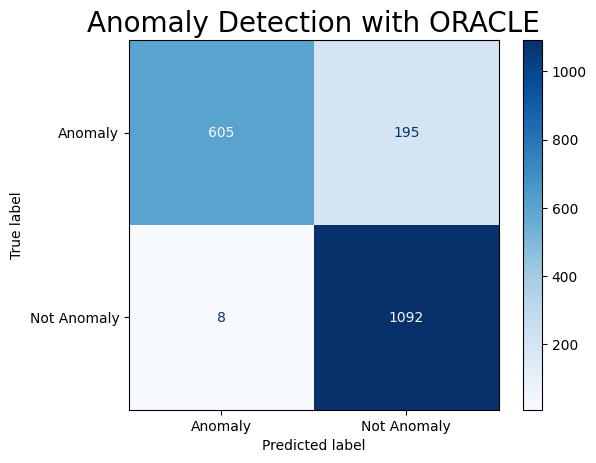

In [21]:
from sklearn import metrics

true = [np.argmax(y_true[i]) for i in range(len(y_true))]
# pred = [np.argmax(y_pred[i]) for i in range(len(y_pred))]
pred = [0 if element > 0.7 else 1 for element in np.transpose(y_pred)[0]]
# pred = [element for element in y_pred]

cm = metrics.confusion_matrix(true, pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Not Anomaly'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Anomaly Detection with ORACLE', fontsize=20.0)
plt.savefig('current_cm.png')
plt.show()

Counter({'CART': 5, 'SNIb/c': 4, 'TDE': 2, 'SNI91bg': 1})
[Text(0.0, 0, '0.0'), Text(0.2, 0, '0.2'), Text(0.4, 0, '0.4'), Text(0.6000000000000001, 0, '0.6'), Text(0.8, 0, '0.8'), Text(1.0, 0, '1.0')]
['SNI91bg', 'CART', 'SNIb/c', 'TDE', ' ']


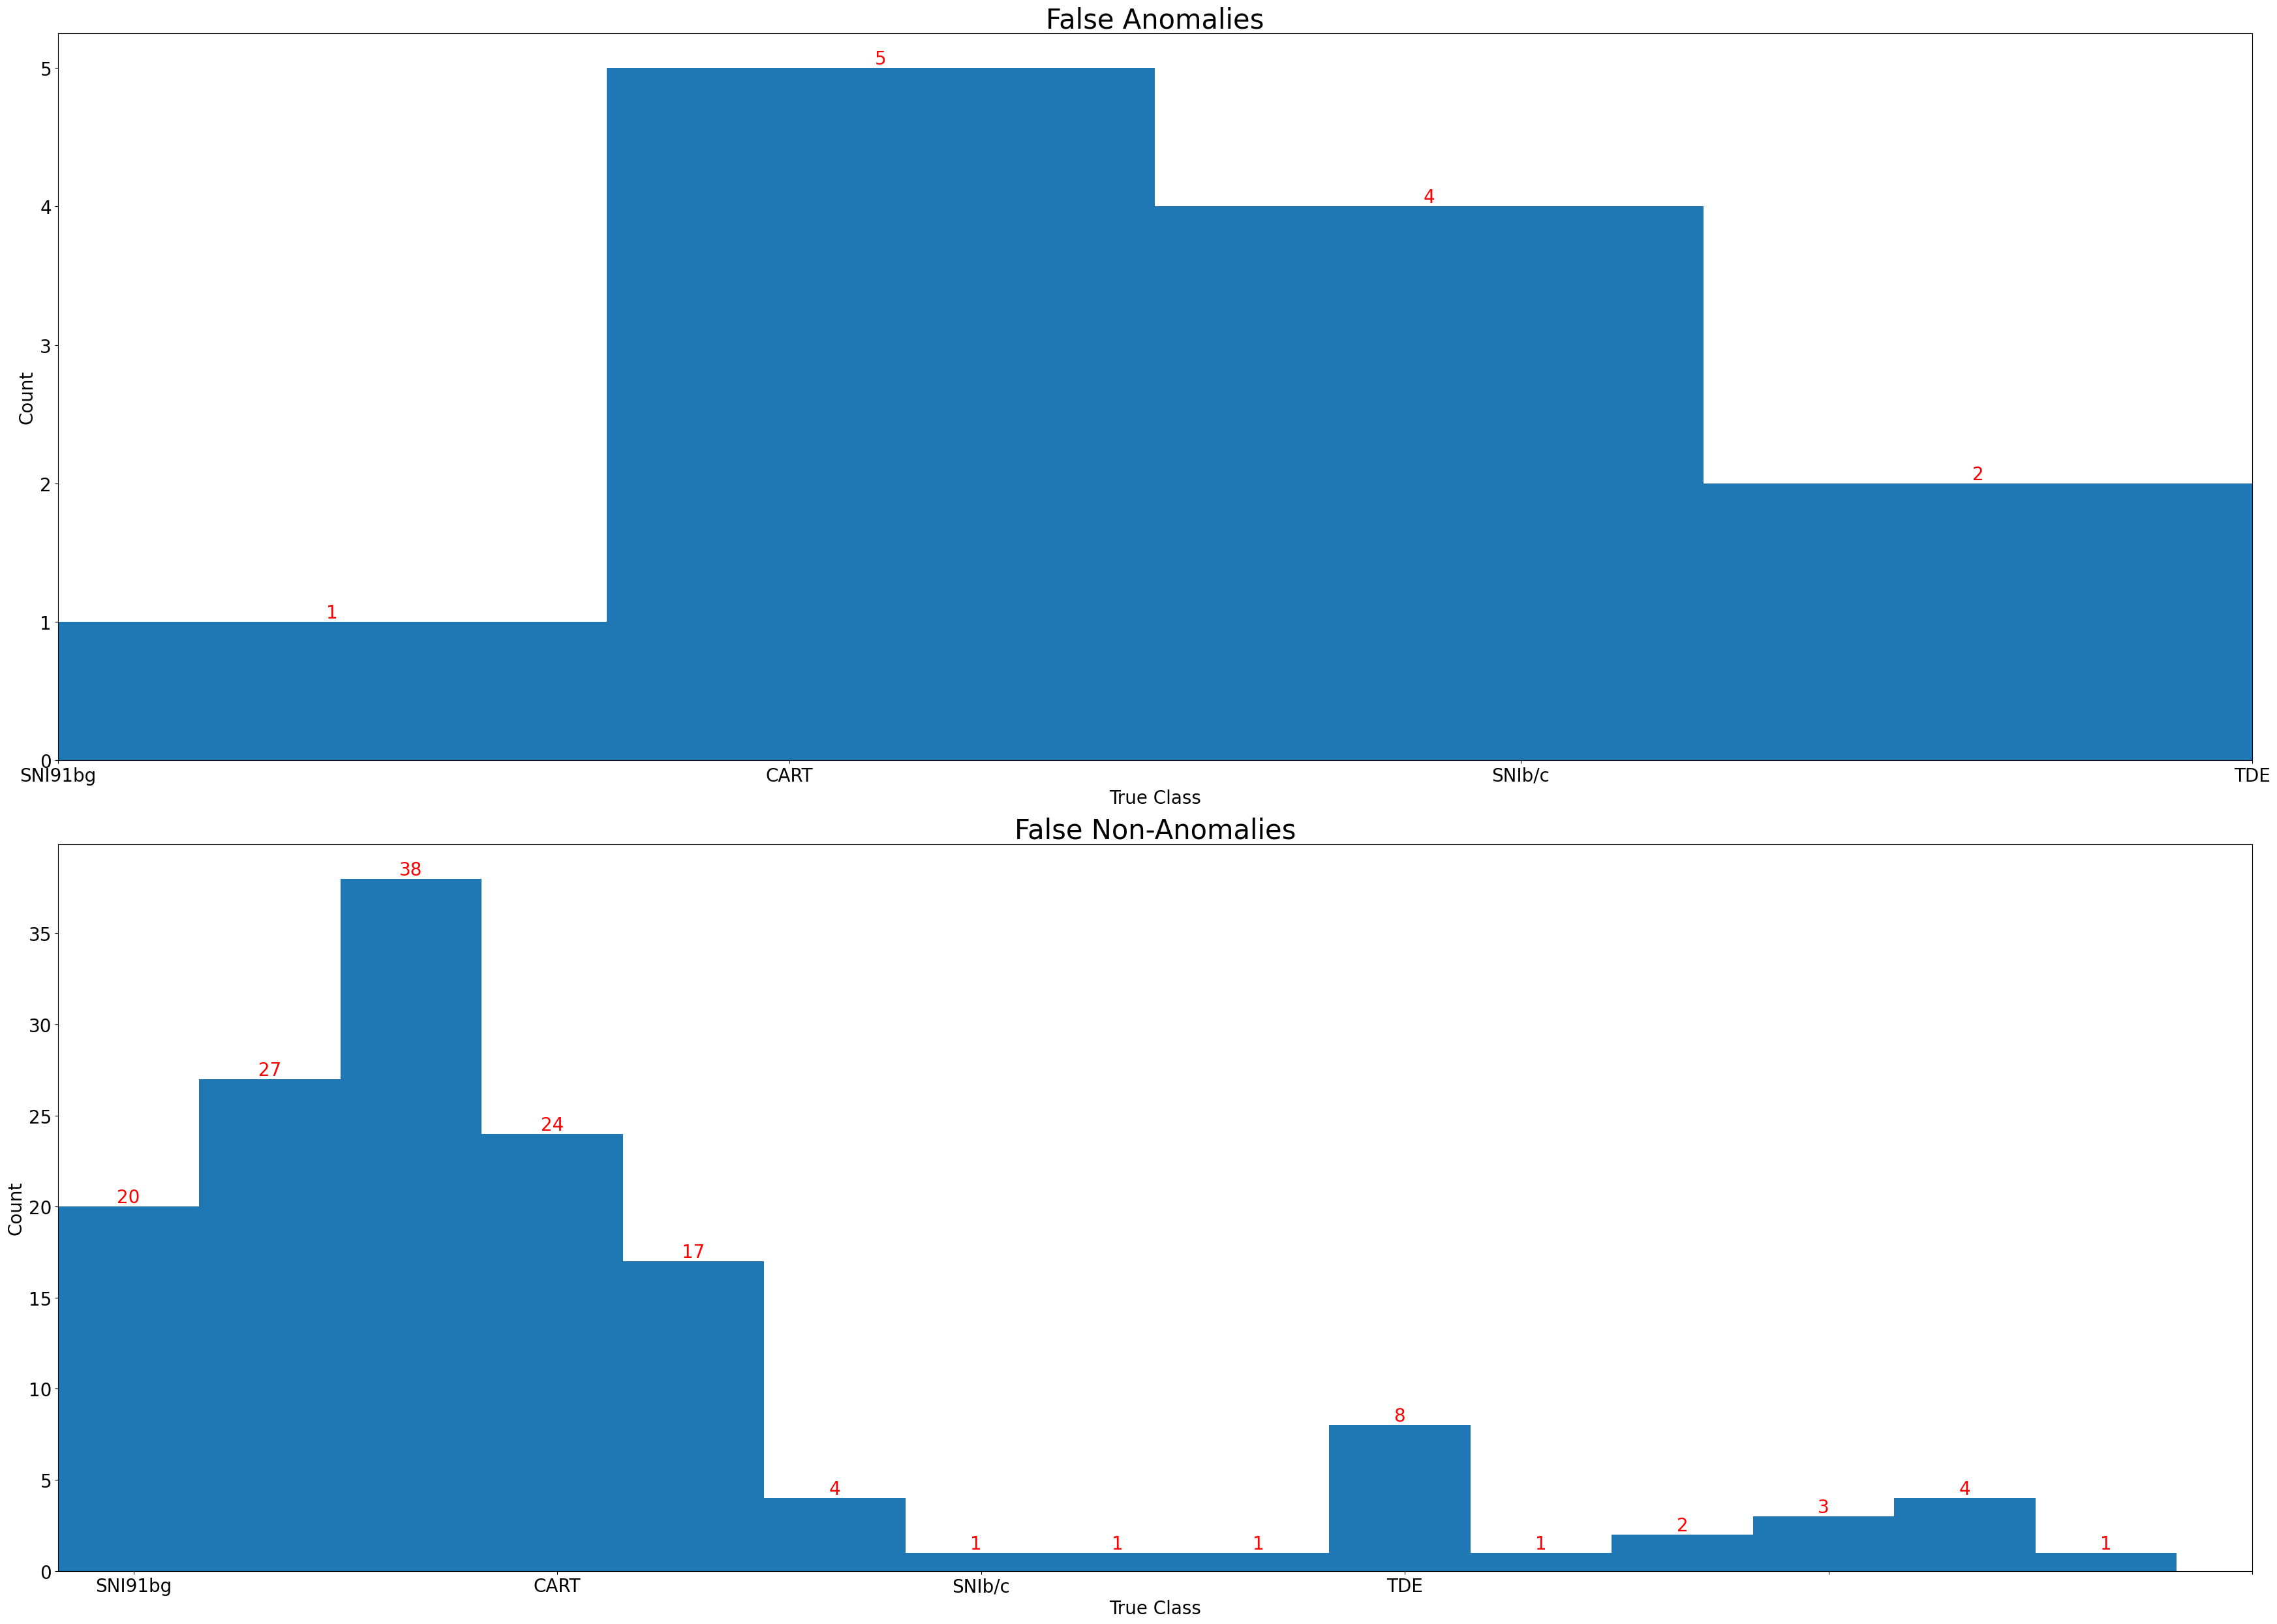

In [114]:
# histogram for falsely predicted class
false_anomalies = []
false_non_anomalies = []

for i in range(len(true)):
    if true[i] == 1 and pred[i] == 0:
        false_anomalies.append(pred_labels[i])
    elif true[i] == 0 and pred[i] == 1:
        false_non_anomalies.append(pred_labels[i])

plot_titles = ['False Anomalies', 'False Non-Anomalies']
x_axes = ['True Class'] * 2
y_axes = ['Count'] * 2
data = [false_anomalies, false_non_anomalies]

from collections import Counter
# print(false_non_anomalies)
# print(len(false_non_anomalies))
print(Counter(false_anomalies))

plt.rc('axes', titlesize=30)

f, a = plt.subplots(2, 1, figsize=(35,25))
a = a.ravel()
for idx,ax in enumerate(a):
    label_names = []
    x_positions = []
    
    values, bins, bars = ax.hist(data[idx], rwidth=1, bins=(4 if idx == 0 else 15))
    ax.set_title(plot_titles[idx])
    ax.set_xlabel(x_axes[idx], fontsize=20.0)
    ax.set_ylabel(y_axes[idx], fontsize=20.0)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.bar_label(bars, fontsize=20, color='r')
    ax.margins(x=0)

    if idx == 0:
        plt.gcf().subplots_adjust(bottom=0.25)
        locs, labels = plt.xticks()
        print(labels)
        label_names = ['SNI91bg', 'CART', 'SNIb/c', 'TDE']
        label_names.append(' ')
        x_positions = np.linspace(0.5, 3.5, len(label_names))
        print(label_names)
        plt.xticks(ticks=x_positions, labels=label_names, rotation=90, ha='center')

    if idx == 1:
        plt.gcf().subplots_adjust(bottom=0.25)
        locs, labels = plt.xticks()
        label_names = [np.array(labels)[i]._text for i in range(len(labels))]
        label_names.append(' ')
        x_positions = np.linspace(0.5, 14.5, len(label_names))
        plt.xticks(ticks=x_positions, labels=label_names, rotation=0, ha='center')

plt.tight_layout()
plt.show()

In [1]:
# histogram for falsely predicted class
false_anomalies = []
false_non_anomalies = []

for i in range(len(true)):
    if true[i] == 1 and pred[i] == 0:
        false_anomalies.append(pred_labels[i])
    elif true[i] == 0 and pred[i] == 1:
        false_non_anomalies.append(pred_labels[i])

plot_titles = ['False Anomalies', 'False Non-Anomalies']
x_axes = ['True Class'] * 2
y_axes = ['Count'] * 2
data = [false_anomalies, false_non_anomalies]

from collections import Counter
# print(false_non_anomalies)
# print(len(false_non_anomalies))
print(Counter(false_anomalies))

plt.rc('axes', titlesize=30)

f, a = plt.subplots(2, 1, figsize=(35,25))
a = a.ravel()
for idx,ax in enumerate(a):
    label_names = []
    x_positions = []
    
    values, bins, bars = ax.hist(data[idx], rwidth=1, bins=(4 if idx == 0 else 15))
    ax.set_title(plot_titles[idx])
    ax.set_xlabel(x_axes[idx], fontsize=20.0)
    ax.set_ylabel(y_axes[idx], fontsize=20.0)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.bar_label(bars, fontsize=20, color='r')
    ax.margins(x=0)

    if idx == 0:
        plt.gcf().subplots_adjust(bottom=0.25)
        locs, labels = plt.xticks()
        print(labels)
        label_names = ['SNI91bg', 'CART', 'SNIb/c', 'TDE']
        label_names.append(' ')
        x_positions = np.linspace(0.5, 3.5, len(label_names))
        print(label_names)
        plt.xticks(ticks=x_positions, labels=label_names, rotation=90, ha='center')

    if idx == 1:
        plt.gcf().subplots_adjust(bottom=0.25)
        locs, labels = plt.xticks()
        label_names = [np.array(labels)[i]._text for i in range(len(labels))]
        label_names.append(' ')
        x_positions = np.linspace(0.5, 14.5, len(label_names))
        plt.xticks(ticks=x_positions, labels=label_names, rotation=0, ha='center')

plt.tight_layout()
plt.show()

NameError: name 'pred' is not defined

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

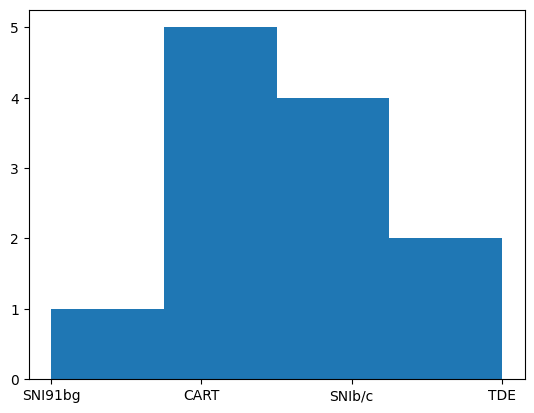

In [108]:
data = [false_anomalies]

x_axes = ['True Class']
y_axes = ['Count']


values, bins, bars = plt.hist(data, rwidth=1, bins=4)
ax.set_title(plot_titles)
ax.set_xlabel(x_axes, fontsize=20.0)
ax.set_ylabel(y_axes, fontsize=20.0)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.bar_label(bars, fontsize=20, color='r')
ax.margins(x=0)

plt.gcf().subplots_adjust(bottom=0.25)
locs, labels = plt.xticks()
print(labels)
label_names = [np.array(labels)[i]._text for i in range(len(labels))]
label_names.append(' ')
x_positions = np.linspace(0.5, 3.5, len(label_names))
print(label_names)

plt.tight_layout()
plt.show()

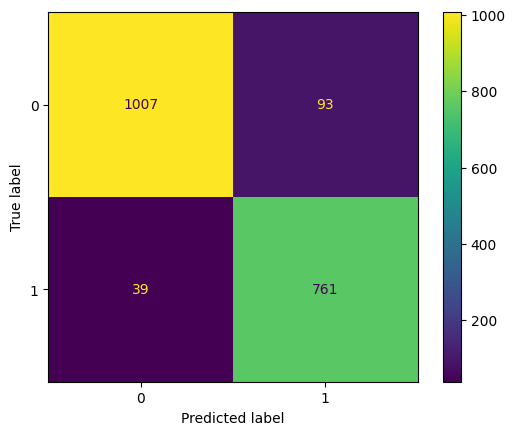

In [93]:
from sklearn import metrics

true = [np.argmax(y_true[i]) for i in range(len(y_true))]
pred = [np.argmax(y_pred[i]) for i in range(len(y_pred))]

cm = metrics.confusion_matrix(true, pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

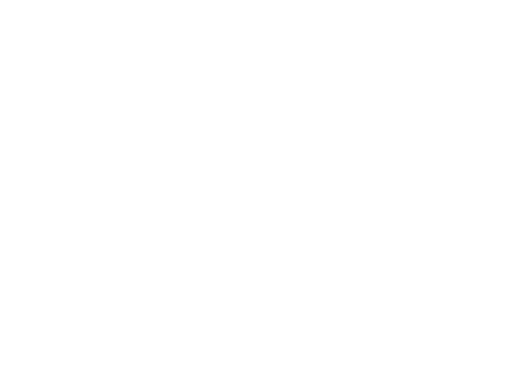

In [39]:
from pandas.plotting import table

ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

report = metrics.classification_report(true, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.index = ['Anomaly', 'Non-Anomaly'] + df.index[2:].tolist()

# table(ax, df)
# plt.savefig('classification_report.png')

dfi.export(df, 'classification_report.png', fontsize=3.8, dpi=800,  table_conversion='celenium', chrome_path=None)

In [31]:
# checking which lightcurves are classified incorrectly
list(enumerate([true[i] == pred[i] for i in range(len(true))]))

[(0, True),
 (1, True),
 (2, True),
 (3, True),
 (4, True),
 (5, True),
 (6, True),
 (7, False),
 (8, False),
 (9, False),
 (10, True),
 (11, True),
 (12, True),
 (13, True),
 (14, True),
 (15, True),
 (16, True),
 (17, True),
 (18, True),
 (19, True),
 (20, True),
 (21, True),
 (22, True),
 (23, True),
 (24, True),
 (25, True),
 (26, True),
 (27, True),
 (28, True),
 (29, True),
 (30, True),
 (31, True),
 (32, True),
 (33, True),
 (34, True),
 (35, True),
 (36, True),
 (37, True),
 (38, True),
 (39, True),
 (40, True),
 (41, True),
 (42, True),
 (43, True),
 (44, False),
 (45, True),
 (46, True),
 (47, True),
 (48, True),
 (49, True),
 (50, True),
 (51, True),
 (52, True),
 (53, True),
 (54, True),
 (55, True),
 (56, True),
 (57, True),
 (58, True),
 (59, True),
 (60, True),
 (61, True),
 (62, True),
 (63, True),
 (64, True),
 (65, True),
 (66, True),
 (67, True),
 (68, False),
 (69, True),
 (70, True),
 (71, True),
 (72, True),
 (73, True),
 (74, False),
 (75, True),
 (76, False),
 (

In [ ]:
# saving model outputs so that they can be used again without having to re-run the model every time
!touch logits.npy

def save_logits():
    with open('logits.npy', 'wb') as f:
        np.save(f, logits)

def load_logits():
    logits = np.load('logits.npy')

# The function calls can be uncommented as needed and then the cell can be run to either save the current predictions or load the previous ones
# save_logits()
# load_logits()

**Visualizing model output**

In [ ]:
import networkx as nx
from taxonomy import source_node_label

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

level_order_nodes = list(nx.bfs_tree(tree, source=source_node_label).nodes())
# print(class_probs[0][0].shape)

class_info = pd.DataFrame()

for index in range(len(class_probs_df)):
    # class_probs_df = [pd.DataFrame(probs).transpose() for probs in class_probs[index][0]]
    class_probs_df = pd.DataFrame(class_probs[index][0]).transpose()
    class_labels_df = pd.DataFrame({"True Class": [true_class_names[index]]})
    class_probs_df[index].columns = level_order_nodes
    class_info_df = pd.concat([class_labels_df, class_probs_df], axis=0)
    class_info = pd.concat([class_info, class_info_df], axis=1)

# class_probs_df[1].columns = level_order_nodes
# class_info = pd.concat([class_labels_df[1], class_probs_df[1]], axis=1)
class_info

In [ ]:
class_probs_df[2].head(2)

In [ ]:
# this output helps visualize the categories that would be classified as anomalous activity
anomaly_labels = class_probs_df[2][['SNIb/c', 'SNIax', 'SNI91bg', 'SNII', 'KN', 'Dwarf Novae', 'uLens', 'M-dwarf Flare', 'SLSN', 'TDE', 'ILOT', 'CART', 'PISN']]
anomaly_labels

**Anomaly Detection Calculations**

Calculating a binary anomaly vs. non-anomaly prediction from the model output. Note, in the output list, the first index of each tuple corresponds to the specific lightcurve in the set, while the second and third elements in the tuple represent the probability of it being an anomaly vs. not being an anomaly).

In [ ]:
model.summary()

In [ ]:
train = LSSTSourceDataSet("./../../train_parquet-001.parquet")
test = LSSTSourceDataSet("./../../test_parquet-002.parquet")

In [ ]:
source, class_labels = train.get_item(9)
table = source.get_event_table()
print(table)
print(table.meta)

In [ ]:
source, class_labels = test.get_item(9)
table = source.get_event_table()
print(table)
print(table.meta)

In [13]:
# # [class_probs[i][0] for i in range(len(class_probs))][0].shape
# # tables.shape
# # X_ts_class[0]
# table = X_ts_class[i]
# # table.to_numpy().shape[0] + 1
# for k in range(1, table.to_numpy().shape[0] + 1):
#     tables = table.to_numpy()[:k, :]
# tables.shape